In [1]:
import torch
import monai
import numpy as np
from src.constants import *
from src.model.baselines import *
from src.data.transforms import train_transform, test_transform, all_transforms
import os
import pickle
from src.utils.metrics import *
from scipy.spatial.distance import directed_hausdorff
from tqdm import tqdm
from src.model.my_model import MyModel


<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
<class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [2]:

filenames = os.listdir(DATA_PATH + "/test_images")
filenames = [f for f in filenames if 'mhd' in f]
test_dataset = monai.data.CacheDataset(filenames, transform=test_transform, num_workers=16)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1, shuffle=False)



Loading dataset: 100%|██████████| 10/10 [01:04<00:00,  6.46s/it]


In [3]:
model_normal = MyModel(in_channels=1,
                out_channels=3,
                lower_channels=16,
                big_channel=16,
                patch_size=8,
                embed_dim=512,
                mode="normal",
                old_embedder=False)

model_skip = MyModel(in_channels=1,
                out_channels=3,
                lower_channels=16,
                big_channel=16,
                patch_size=8,
                embed_dim=512,
                mode="skip",
                old_embedder=False)


model_no_down_vit = MyModel(in_channels=1,
                out_channels=3,
                lower_channels=16,
                big_channel=16,
                patch_size=8,
                embed_dim=512,
                mode="no_down_vit",
                old_embedder=False)

model_auto = MyModel(in_channels=1,
                out_channels=3,
                lower_channels=16,
                big_channel=16,
                patch_size=8,
                embed_dim=512,
                mode="skip",
                old_embedder=False)

model_half_half = MyModel(in_channels=1,
                out_channels=3,
                lower_channels=16,
                big_channel=16,
                patch_size=8,
                embed_dim=512,
                mode="normal",
                old_embedder=False)

model_no_vit = MyModel(in_channels=1,
                out_channels=3,
                lower_channels=16,
                big_channel=16,
                patch_size=8,
                embed_dim=512,
                mode="no_down_vit",
                old_embedder=False)

In [4]:
model_normal.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/new_16_512_0.8448749532302221.pt"))
model_skip.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/new_skip_0.8574683298667272.pt"))
model_no_down_vit.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/just_one_level_vit_0.5714183449745179.pt"))
model_auto.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/new_skip_0.812130691607793.pt"))
model_half_half.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/new_16_512_0.8250120381514231.pt"))
model_no_vit.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/just_one_level_vit_0.5234204106653729.pt"))

<All keys matched successfully>

In [5]:
def segment(model, img):   
    model.eval().cuda()

    largest_component = monai.transforms.KeepLargestConnectedComponent()

    with torch.no_grad():

        img = img.to(DEVICE)

        out = monai.inferers.sliding_window_inference(img,
                                                      roi_size=CROP_SIZE,
                                                      sw_batch_size=BATCH_SIZE,
                                                      predictor=model,
                                                      overlap=0.8,
                                                      sw_device=DEVICE,
                                                      device="cpu",
                                                      progress=True,
                                                      mode="gaussian")
        out = torch.argmax(out, 1, keepdim=True).to(DEVICE)
        out_k = largest_component(out)
        
        model = model.cpu()
        torch.cuda.empty_cache()
        return out_k.detach().cpu().numpy()


In [9]:
l = [x for x in test_loader]

img = l[7]['img']
mask = l[7]['mask']

out = segment(model_skip(img))

np.save(open(f'{GENERAL_PATH}/out/img/slides_out.npy', 'wb'), out)
np.save(open(f'{GENERAL_PATH}/out/img/slides_img.npy', 'wb'), img.cpu().numpy()[0, 0])
np.save(open(f'{GENERAL_PATH}/out/img/slides_mask.npy', 'wb'), mask.cpu().numpy())

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 39 for tensor number 1 in the list.

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def visualize_sample_to_wandb(image, label, outs, slice_idx=320):

    # image = image.cpu().numpy()
    # label = label.cpu().numpy()
    # prediction = prediction.cpu().numpy()

    # Force a 2D example where at least one class is present
        # Choose a random slice index
        # slice_idx = np.random.randint(0, image.shape[2])

    # Extract the 2D slices
    image_slice = image[0, 0, slice_idx, :, :]
    label_slice = label[0, 0, slice_idx, :, :]
    outs = [o[0, 0, slice_idx, :, :] for o in outs]

    cmap = ListedColormap(['none', 'red', 'yellow'])
    # Plot the slices
    fig, axs = plt.subplots(7, 2, figsize=(2*5+1, 7*5))
    # fig.suptitle(f'Scores of this slice: {scores}')
# display the original image

    axs[0, 0].imshow(label_slice, cmap="gray")
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])

    axs[0, 1].imshow(image_slice, cmap="gray")
    axs[0, 1].imshow(label_slice, cmap=cmap, alpha=0.3)
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])

    for i in range(6):
        
        axs[i+1, 0].imshow(outs[i], cmap="gray")
        axs[i+1, 0].set_xticks([])
        axs[i+1, 0].set_yticks([])
        
        axs[i+1, 1].imshow(image_slice, cmap="gray")
        axs[i+1, 1].imshow(outs[i], cmap=cmap, alpha=0.3)
        axs[i+1, 1].set_xticks([])
        axs[i+1, 1].set_yticks([])
        
        

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{GENERAL_PATH}/out/img/{slice_idx}_new.png', dpi=500)
    plt.show()
    plt.close(fig)
    
    
    plt.imshow(image_slice, cmap="gray")
    plt.tight_layout()
    plt.savefig(f'{GENERAL_PATH}/out/img/{slice_idx}_original.png', dpi=500)

    

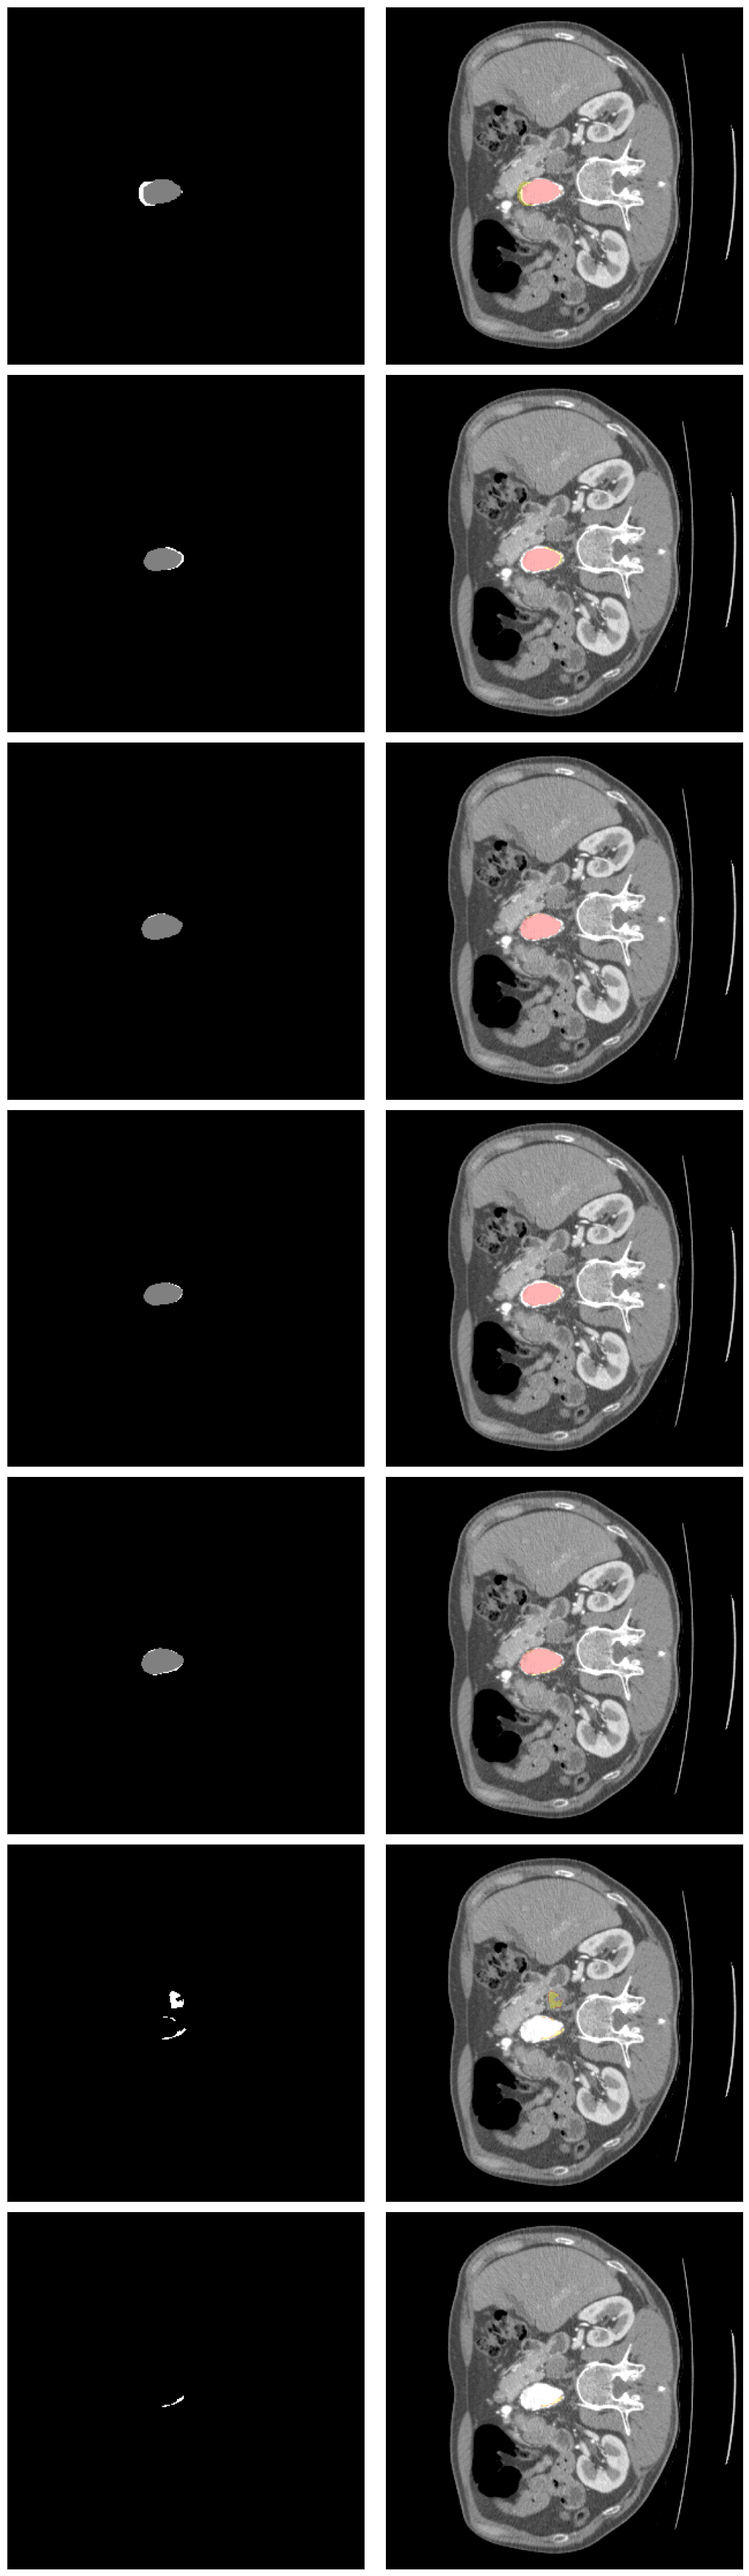

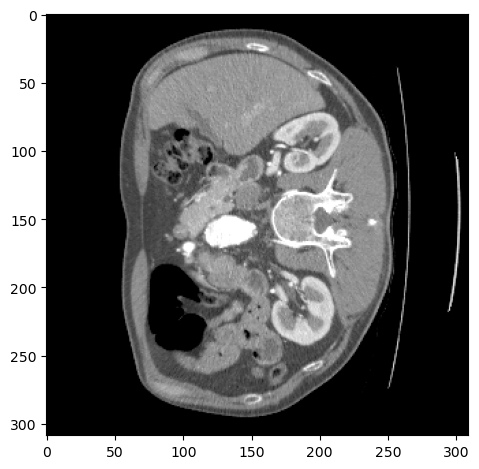

In [43]:
visualize_sample_to_wandb(img, mask, [out_1, out_2, out_5, out_4, out_3, out_6], slice_idx=345)

In [23]:
# out_1 = segment(model_normal, img)
# out_2 = segment(model_skip, img)
# out_3 = segment(model_no_down_vit, img)
# out_4 = segment(model_auto, img)
# out_5 = segment(model_half_half, img)
out_6 = segment(model_no_vit, img)



100%|██████████| 486/486 [02:19<00:00,  3.48it/s]


In [14]:
np.save(f"{GENERAL_PATH}/out/img/out_mask.npy", mask)

In [18]:
mask

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

In [29]:
from monai.data import ImageWriter

tensor = torch.from_numpy(out_1)

# Define metadata including voxel spacing
meta_data = {'spacing': (1.2, 1.2, 0.9), 'filename_or_obj': f"{GENERAL_PATH}/out/img/lol.mhd"}

# Create an ImageWriter
writer = ImageWriter()

# Write the image
writer.write(tensor, meta_data)

2023-06-06 16:34:05,321 INFO image_writer.py:194 - writing: tensor([[[[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],

          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],

          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],

          ...,

          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
   

In [ ]:
visualize_sample_to_wandb(img, mask, out_1)
visualize_sample_to_wandb(img, mask, out_2)
visualize_sample_to_wandb(img, mask, out_3)
visualize_sample_to_wandb(img, mask, out_4)
visualize_sample_to_wandb(img, mask, out_5)
visualize_sample_to_wandb(img, mask, out_6)

In [ ]:
visualize_sample_to_wandb(img, mask, out_1, 200)
visualize_sample_to_wandb(img, mask, out_1, 270)
visualize_sample_to_wandb(img, mask, out_1, 300)
visualize_sample_to_wandb(img, mask, out_1, 320)
visualize_sample_to_wandb(img, mask, out_1)
visualize_sample_to_wandb(img, mask, out_1)